# Assignment 8

In this assignment we'll estimate a regression model using the horseshoe prior. We're going to analyze [some data I found on Kaggle](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction) and try to predict the price of flights. 

## Instructions

Please complete this Jupyter notebook and **don't** convert it to a `.py` file. Upload this notebook, along with any `.stan` files and any data sets as a `zip` file to Gradescope. Your work will be manually graded by our TA. 


### Data Cleaning

I will make some transformations to prepare this data set for regression:

 - create dummy columns for the categorical data,
 - transform price to log price,
 - create interaction terms.

Note that my decision to disregard certain columns, or interactions or transformations is a reflection of my prior knowledge. Ommitting a column is equivalent to setting a very informative prior for that hypothetical column's weight (centered at $0$). Commonly performed procedures have a place in the Bayesian philosophy, and are not as ad hoc as they seem to be in the frequentist domain!

In [2]:
import pandas as pd
import numpy as np
import os
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt

In [9]:
flights = pd.read_csv("Clean_Dataset.csv", index_col=0)
flights.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [10]:
# change dependent variabe by taking the logarithm
flights['log_price'] = np.log(flights['price'])
flights = flights.drop('price', axis=1)

In [11]:
# create airlines dummies
# baseline is "other" (AirAsia","GO_FIRST", or "SpiceJet")
airline_dummies = pd.get_dummies(flights['airline']).astype(float)
airline_dummies = airline_dummies.drop(["AirAsia","GO_FIRST","SpiceJet"],axis=1)

In [12]:
# one dummy for business class (baseline is economy)
class_dummies = pd.get_dummies(flights['class']).astype(float)
class_dummies = class_dummies['Business']
class_dummies.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Business, dtype: float64

In [13]:
# create predictor matrix
X = pd.concat([flights[['duration', 'days_left']], airline_dummies, class_dummies], axis=1)
X.head()

,duration,days_left,Air_India,Indigo,Vistara,Business
0,2.17,1,0.0,0.0,0.0,0.0
1,2.33,1,0.0,0.0,0.0,0.0
2,2.17,1,0.0,0.0,0.0,0.0
3,2.25,1,0.0,0.0,1.0,0.0
4,2.33,1,0.0,0.0,1.0,0.0


## Problem 1: Running MCMC

There's a lot of data here, which means running MCMC the way we typically do is going to take a long time. Let's start by only using some of the rows. Feel free to adjust the variable below to keep as many rows as you want--the lower the number the faster your code. 

Note that your inferences will be compromised because we are throwing away data, in a sense, but we need to keep this data manageable, especially while we're getting our code ready for prime time. 

Do not run a variational algorithm yet! We'll do that in the next problem!

Note that if you keep too few rows, there's a chance that a dummy column will have all $1$s or all $0$s. This is a problem because it will introduce collinearity. Also, it will make those predictors look unimportant even when they are!

We shuffle the rows before selecting some of them to reduce the chances this happens. We also check to make sure indicator columns are not all $1$ or all $0$. If they were, the column average would be $1$ or $0$ exactly 

In [14]:
num_rows_to_keep = 100 # change me if you want!
row_indexes = np.arange(0,X.shape[0])
np.random.shuffle(row_indexes)
rows_to_keep = row_indexes[0:num_rows_to_keep]
baby_X = X.iloc[rows_to_keep,]
baby_y = flights.loc[rows_to_keep,'log_price']
baby_X.mean(axis=0)

duration     11.3739
days_left    23.4700
Air_India     0.2100
Indigo        0.1600
Vistara       0.4100
Business      0.2300
dtype: float64

1.

Write `.stan` file and estimate your model using the NUTS algorithm.

In [24]:
baby_X = baby_X.dropna()
baby_y = baby_y.loc[baby_X.index]

baby_X = baby_X.loc[:, (baby_X != baby_X.iloc[0]).any()]

baby_X = baby_X.loc[:, baby_X.std() > 1e-8]

assert not baby_X.isnull().values.any(), "NaNs in baby_X"
assert not baby_y.isnull().values.any(), "NaNs in baby_y"
assert np.isfinite(baby_X.values).all(), "Non-finite in baby_X"
assert np.isfinite(baby_y.values).all(), "Non-finite in baby_y"
assert np.abs(baby_X.values).max() < 1e6, "Suspiciously large values in X"

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(baby_X)

stan_data = {
    'N': baby_X.shape[0],
    'K': baby_X.shape[1],
    'X': X_scaled,
    'y': baby_y.values
}

In [27]:
model = CmdStanModel(stan_file='horseshoe_regression.stan')

fit = model.sample(
    data=stan_data,
    chains=4,
    parallel_chains=4,
    iter_sampling=1000,
    iter_warmup=500,
    seed=123
)

10:45:01 - cmdstanpy - INFO - compiling stan file /sfs/gpfs/tardis/home/jbm2rt/Documents/MSDS/DS6040/M8/horseshoe_regression.stan to exe file /sfs/gpfs/tardis/home/jbm2rt/Documents/MSDS/DS6040/M8/horseshoe_regression
10:45:20 - cmdstanpy - INFO - compiled model executable: /sfs/gpfs/tardis/home/jbm2rt/Documents/MSDS/DS6040/M8/horseshoe_regression
10:45:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:45:23 - cmdstanpy - INFO - CmdStan done processing.
10:45:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 24 divergent transitions (2.4%)
	Chain 2 had 17 divergent transitions (1.7%)
	Chain 3 had 6 divergent transitions (0.6%)
	Chain 4 had 68 divergent transitions (6.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [20]:
print(fit.summary())

                Mean      MCSE     StdDev       MAD         5%        50%  \
lp__       41.503200  0.189417   3.660200  3.531630  34.860500  42.020700   
alpha       8.797920  0.007495   0.094960  0.099230   8.636320   8.802720   
sigma       0.345946  0.000560   0.024647  0.023177   0.306833   0.345479   
z[1]        0.419881  0.020225   0.444196  0.238083   0.041288   0.239027   
z[2]       -0.420542  0.035622   0.442787  0.287870  -1.369670  -0.263883   
z[3]        0.638839  0.110046   0.638020  0.593322  -0.194108   0.582515   
z[4]        0.320116  0.016989   0.652591  0.438410  -0.776740   0.276307   
z[5]        0.953657  0.017844   0.565190  0.499872   0.204086   0.818465   
z[6]        1.134250  0.050956   0.623264  0.617095   0.311598   1.012290   
tau         0.343143  0.007912   0.262548  0.175503   0.073002   0.286285   
lambda[1]   0.475351  0.016543   0.649149  0.300963   0.036148   0.327877   
lambda[2]   0.626527  0.251872   0.824287  0.322839   0.037570   0.302508   

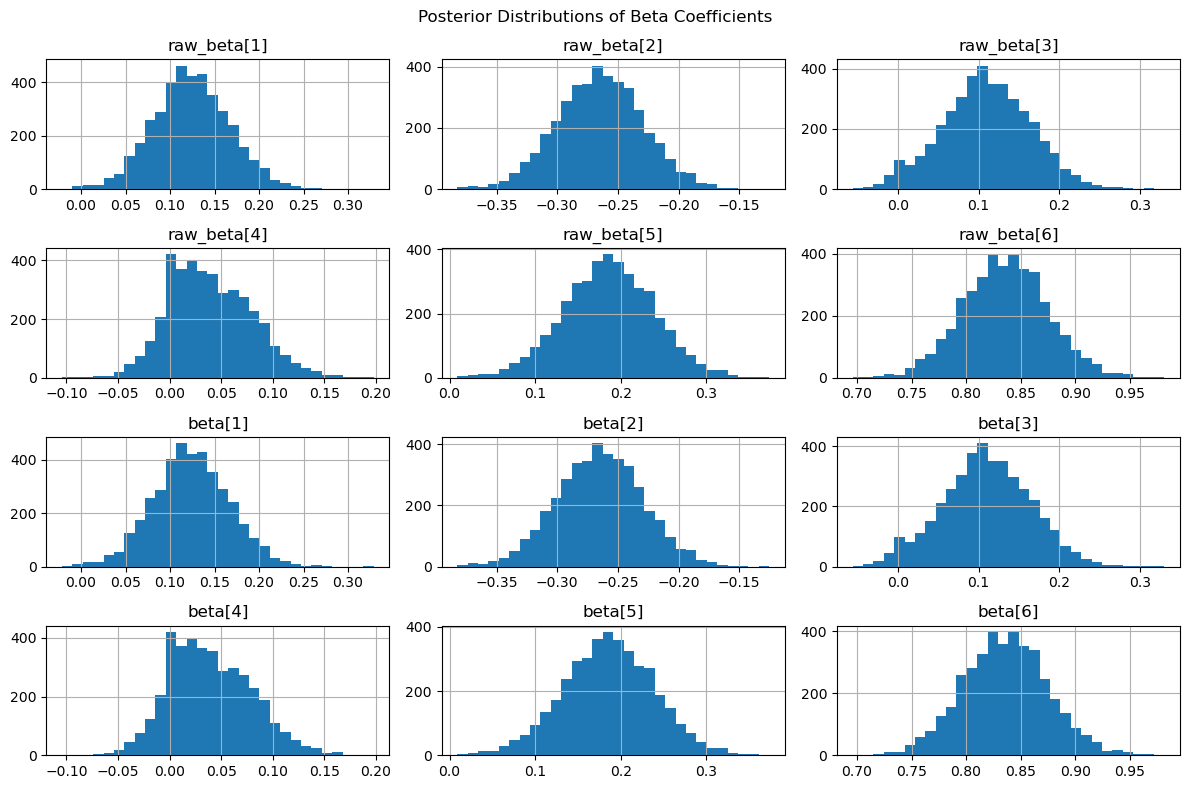

In [28]:
posterior = fit.draws_pd()

posterior.filter(like='beta', axis=1).hist(bins=30, figsize=(12, 8))
plt.suptitle('Posterior Distributions of Beta Coefficients')
plt.tight_layout()
plt.show()

2.

Write code to check that **all** of your $\hat{R}$ convergence diagnostics. Use a threshold of $1.01$. Be honest!

You might see some warnings about "divergent transitions." This means that the geometry of the posterior is relatively complicated, and the NUTS algorithm isn't having as easy of a time with it. This is common with the horseshoe prior.

The warnings can be addressed by 

 - re-tuning the NUTS algorithm (not discussed),
 - writing the horseshoe prior differently in our `.stan` file (not discussed), or
 - **just running the NUTS sampler for longer.** 

Indeed, $\hat{R}$ will still be our metric to tell us if we didn't run our chain for long enough. If all of them are below $1.01$, then you can ignore the warnings. 



In [29]:
summary_df = fit.summary()

# Check R-hat values
high_rhat = summary_df[summary_df['R_hat'] >= 1.01]

print(f"Total parameters: {summary_df.shape[0]}")
print(f"Parameters with R-hat ≥ 1.01: {high_rhat.shape[0]}")

if not high_rhat.empty:
    print("Parameters with high R-hat:")
    display(high_rhat)
else:
    print("All R-hat values are below 1.01. Convergence looks good!")


Total parameters: 36
Parameters with R-hat ≥ 1.01: 1
Parameters with high R-hat:


,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
z[6],1.23272,0.029305,0.588802,0.595319,0.355879,1.16302,2.29063,285.285,101.222,1.01281


I checked all R-hat values using a threshold of 1.01.

- The parameter `z[6]` had R-hat = 1.01281, slightly above the threshold.

This suggests that convergence for this parameter may not be perfect. Given that only one parameter is affected and the deviation is minor, overall convergence appears acceptable. Increasing the number of iterations could help improve convergence further if needed.

3.

What is the estimate of the intercept? What is its interpretation? What is a credible interval for this quantity? Provide an accompanying histogram.

In [31]:
alpha_samples = posterior["alpha"]

alpha_mean = alpha_samples.mean()
alpha_ci = alpha_samples.quantile([0.05, 0.95])

print(f"Intercept (alpha) estimate: {alpha_mean:.4f}")
print(f"90% credible interval: [{alpha_ci.iloc[0]:.4f}, {alpha_ci.iloc[1]:.4f}]")

Intercept (alpha) estimate: 9.1921
90% credible interval: [9.1377, 9.2488]


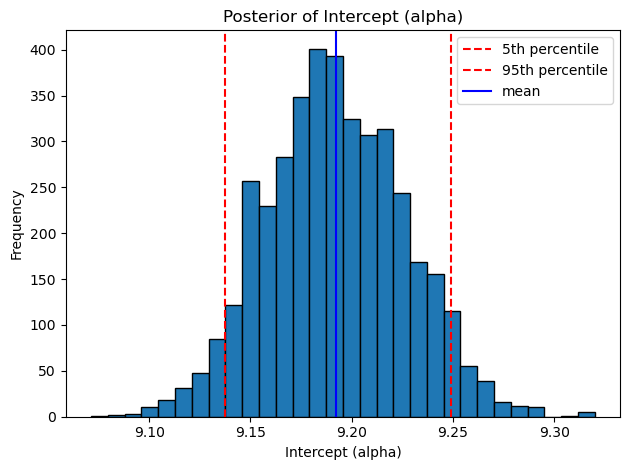

In [32]:
plt.hist(alpha_samples, bins=30, edgecolor='k')
plt.axvline(alpha_ci.iloc[0], color='red', linestyle='--', label='5th percentile')
plt.axvline(alpha_ci.iloc[1], color='red', linestyle='--', label='95th percentile')
plt.axvline(alpha_mean, color='blue', linestyle='-', label='mean')
plt.title('Posterior of Intercept (alpha)')
plt.xlabel('Intercept (alpha)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

Intercept (alpha) estimate: 9.1921

90% credible interval: [9.1377, 9.2488]

The intercept represents the expected value of `log(price)` when all predictors are zero. Since the predictor variables were standardized before fitting the model, this corresponds to the expected log flight price for a flight with:
- average duration,
- average days left until departure,
- a baseline airline (AirAsia, GO_FIRST, or SpiceJet),
- and economy class.

This estimate gives us a baseline log-price for an "average" flight in the dataset. The 90% credible interval [9.1377, 9.2488] reflects the posterior uncertainty around this estimate.

4.

What is the estimate of the standard deviation of the noise? What is its interpretation? What is a credible interval for this quantity? Provide an accompanying histogram.

In [33]:
sigma_samples = posterior["sigma"]

sigma_mean = sigma_samples.mean()
sigma_ci = sigma_samples.quantile([0.05, 0.95])

print(f"Noise std deviation (sigma) estimate: {sigma_mean:.4f}")
print(f"90% credible interval: [{sigma_ci.iloc[0]:.4f}, {sigma_ci.iloc[1]:.4f}]")

Noise std deviation (sigma) estimate: 0.3446
90% credible interval: [0.3043, 0.3919]


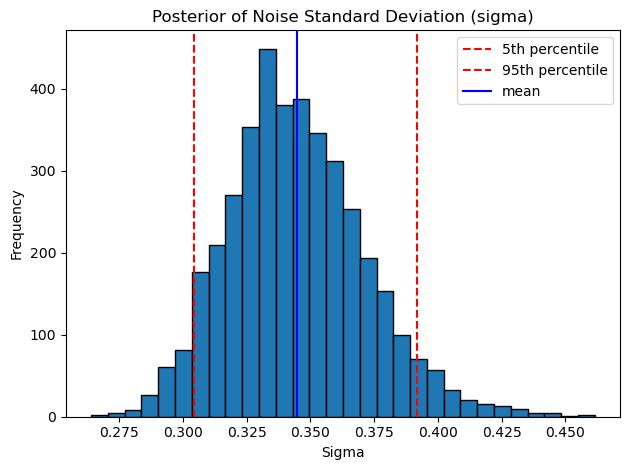

In [34]:
plt.hist(sigma_samples, bins=30, edgecolor='k')
plt.axvline(sigma_ci.iloc[0], color='red', linestyle='--', label='5th percentile')
plt.axvline(sigma_ci.iloc[1], color='red', linestyle='--', label='95th percentile')
plt.axvline(sigma_mean, color='blue', linestyle='-', label='mean')
plt.title('Posterior of Noise Standard Deviation (sigma)')
plt.xlabel('Sigma')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

Posterior mean of the noise standard deviation (sigma): 0.3446

90% credible interval: [0.3043, 0.3919]

The standard deviation of the noise term quantifies how much the actual log flight prices deviate from the values predicted by the model. In other words, it reflects the typical unexplained variation in `log(price)` after accounting for all included predictors.

A sigma of 0.3446 suggests moderate residual variability in log prices. The 90% credible interval [0.3043, 0.3919] reflects the posterior uncertainty about this level of noise.

5.

Use a scatterplot matrix and some credible intervals to visualize the $\beta$ weight samples. Do any of the predictors look unimportant? Do any of them look correlated?



In [38]:
# Extract beta columns
beta_cols = [col for col in posterior.columns if col.startswith("beta[")]
beta_samples = posterior[beta_cols]
beta_samples.columns = [f"Beta{i+1}" for i in range(len(beta_cols))]

/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


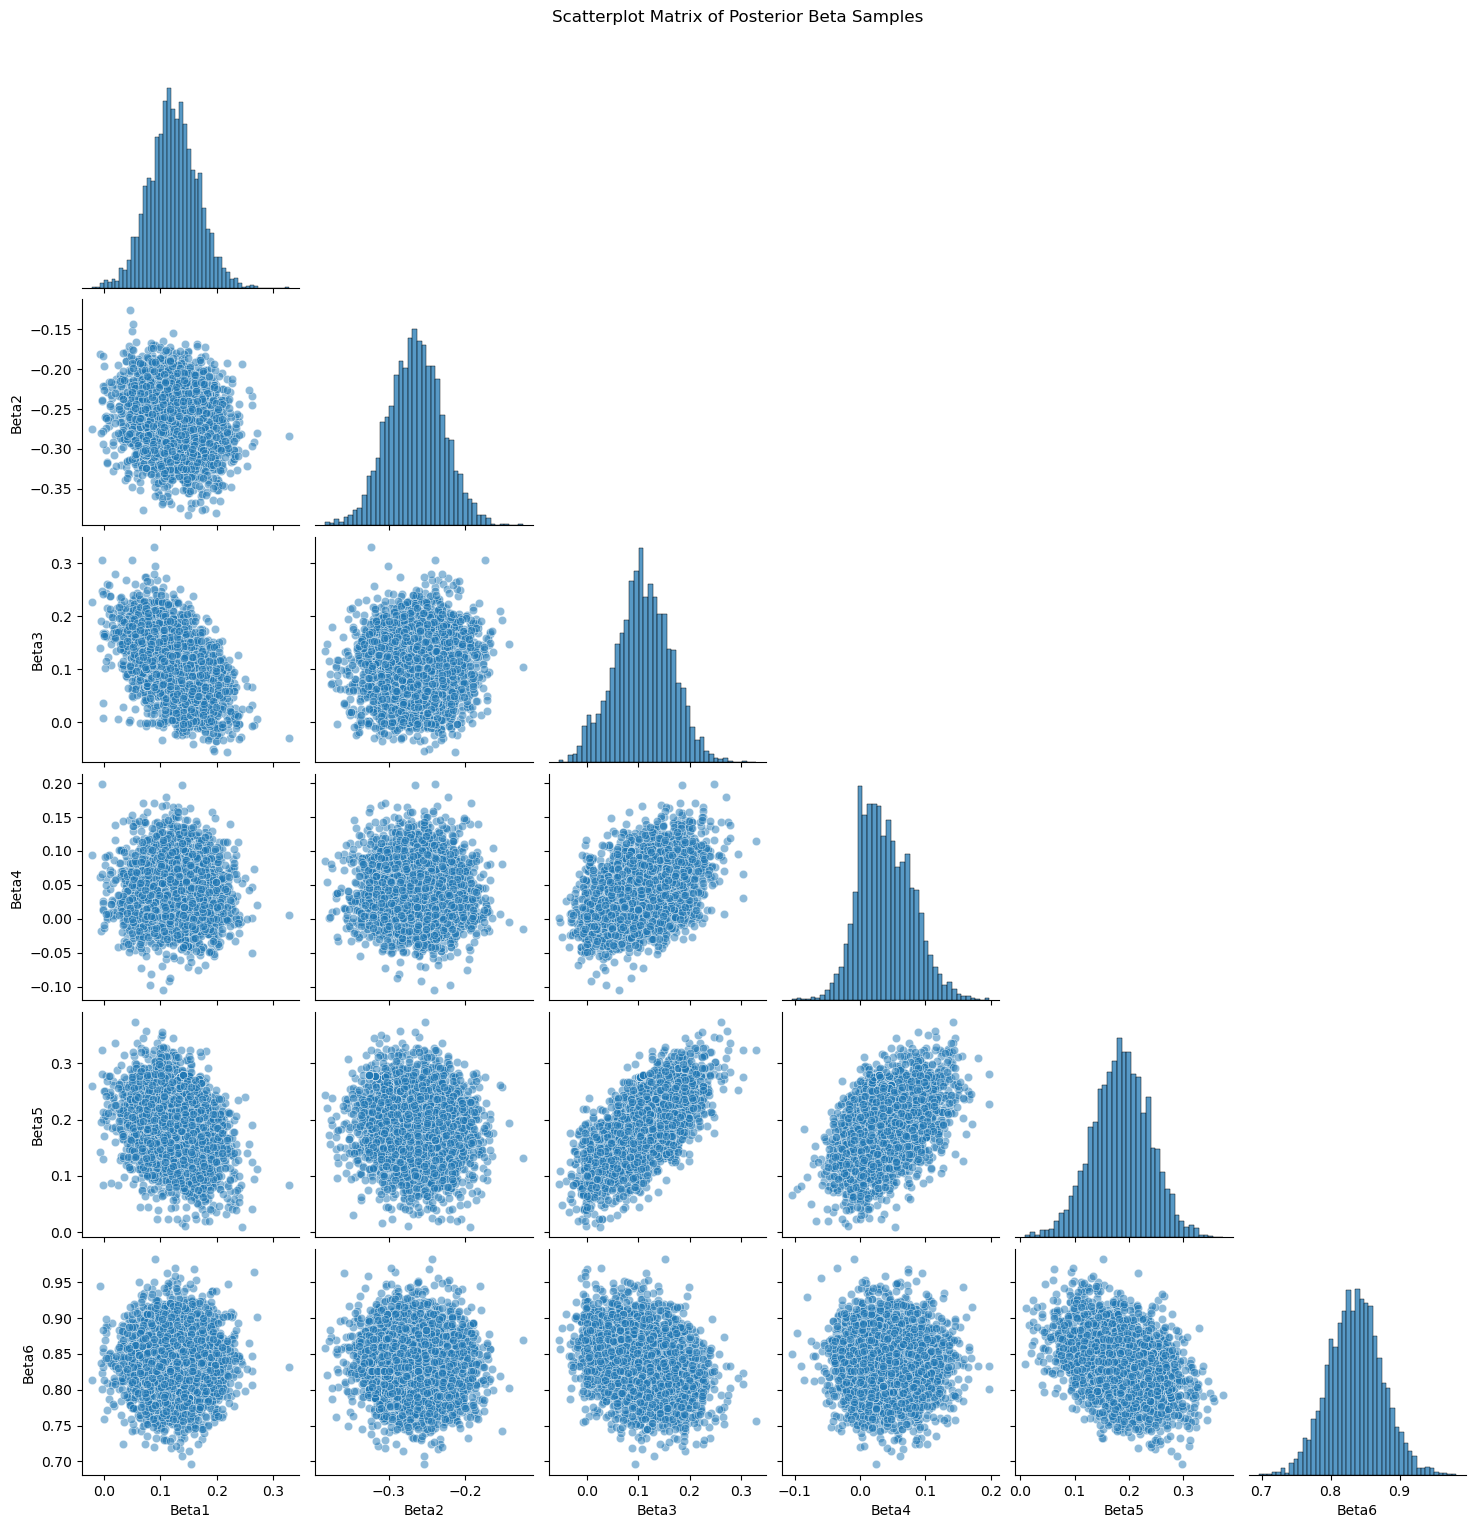

In [39]:
import seaborn as sns
sns.pairplot(beta_samples, corner=True, plot_kws={'alpha': 0.5})
plt.suptitle('Scatterplot Matrix of Posterior Beta Samples', y=1.02)
plt.show()

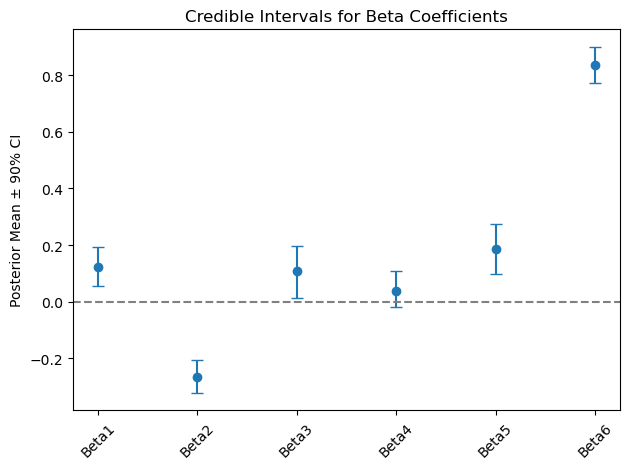

In [40]:
# Compute 90% credible intervals
beta_summary = beta_samples.apply(
    lambda col: pd.Series({
        'mean': col.mean(),
        '5%': col.quantile(0.05),
        '95%': col.quantile(0.95)
    })
).T

# Plot intervals
plt.errorbar(
    x=range(len(beta_summary)),
    y=beta_summary['mean'],
    yerr=[
        beta_summary['mean'] - beta_summary['5%'],
        beta_summary['95%'] - beta_summary['mean']
    ],
    fmt='o',
    capsize=4
)
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(range(len(beta_summary)), beta_summary.index, rotation=45)
plt.ylabel('Posterior Mean ± 90% CI')
plt.title('Credible Intervals for Beta Coefficients')
plt.tight_layout()
plt.show()

The 90% credible intervals for the beta coefficients suggest that most predictors contribute meaningfully to the model:

- **beta6** has the largest magnitude, with its entire credible interval well above zero. This indicates strong evidence that the associated predictor has a large positive effect on log(price).
- **beta2** has a credible interval entirely below zero, suggesting a consistent negative association.
- **beta1, beta3, and beta5** have credible intervals that exclude zero, indicating modest but non-negligible effects.
- **beta4** is the only coefficient whose 90% credible interval includes zero, suggesting that the corresponding predictor may not be important for predicting log(price) when the other variables are included.

In the scatterplot matrix, some posterior correlations between coefficients are visible:

- **beta3 and beta1** show a negative correlation,
- **beta3 and beta5**, and **beta4 and beta5** are positively correlated,
- **beta5 and beta6** show a negative correlation.

These patterns may suggest mild collinearity or shared predictive roles between some features. However, the correlations are not extreme, and the horseshoe prior likely mitigates any major issues from collinearity by shrinking unimportant coefficients toward zero.

6.

Pick an arbitrary observation number (call it $i$). This corresponds to the index of a row in your predictor matrix. 

Plot the posterior predictions for $\tilde{y}_i$ for this particular predictor. There are many simulations for this one quantity.

Compare them to the actual dependent observation at that row $y_i$. Ideally your $y_i$ should be in the center of the histogram of predictions. Overlay a vertical line to show where this $y_i$ is.

Once you're convinced you have working code, copy/paste it into a function definition so that you can quickly switch between different predictions. 

NB: `stan` indexes start at $1$, while Python indexes start at $0$!

In [41]:
def plot_posterior_predictive_one_predictor(arb_row):
    import matplotlib.pyplot as plt
    import numpy as np

    # Extract alpha and beta samples
    alpha_samples = posterior["alpha"].values
    beta_cols = [col for col in posterior.columns if col.startswith("beta[")]
    beta_samples = posterior[beta_cols].values

    # Get X row (row i) — NOTE: Python is 0-based
    x_row = X_scaled[arb_row, :]  # this assumes X_scaled is a NumPy array

    # Compute mu_tilde (predicted log-price, no noise yet)
    mu_tilde = alpha_samples + beta_samples @ x_row

    # Draw from posterior predictive: y_tilde ~ Normal(mu_tilde, sigma)
    sigma_samples = posterior["sigma"].values
    y_tilde_samples = np.random.normal(loc=mu_tilde, scale=sigma_samples)

    # Get actual value
    y_actual = baby_y.iloc[arb_row]

    # Plot
    plt.hist(y_tilde_samples, bins=30, edgecolor='k', alpha=0.7)
    plt.axvline(y_actual, color='red', linestyle='--', label=f'Actual log(price): {y_actual:.2f}')
    plt.title(f'Posterior Predictive Distribution for Row {arb_row}')
    plt.xlabel('Predicted log(price)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

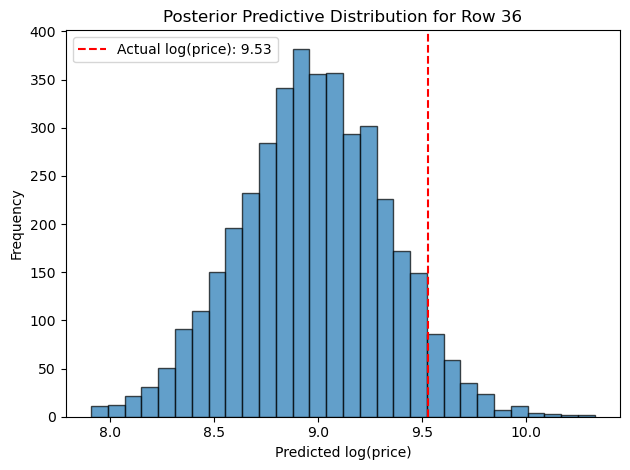

In [46]:
plot_posterior_predictive_one_predictor(36)

The function `plot_posterior_predictive_one_predictor()` was used to visualize the posterior predictive distribution for an arbitrary observation (e.g., row 40). The actual observed log-price was overlaid as a red dashed line on the histogram of simulated predictions.

In this example, the actual value did not fall exactly at the center of the distribution, but it was within approximately one posterior standard deviation of the mode. This suggests that the model's prediction for this observation is reasonable, though not perfect — a reflection of the residual noise captured by the posterior samples of sigma.

## Problem 2: Running Variational Inference Algorithms

There's a lot of data here, which means we had to ignore it to quickly run MCMC, especially while we were prototyping. 

Use a variational inference algorithm on the full data set now. Do not recompile your stan model. You don't need to. This took a few minutes on my machine.


In [48]:
scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(X)

In [49]:
stan_data_full = {
    'N': X_full_scaled.shape[0],
    'K': X_full_scaled.shape[1],
    'X': X_full_scaled,
    'y': flights['log_price'].values
}

In [50]:
vi_fit = model.variational(data=stan_data_full, seed=123, output_samples=1000)

11:27:17 - cmdstanpy - WARNING - Argument name `output_samples` is deprecated, please rename to `draws`.
11:27:20 - cmdstanpy - INFO - Chain [1] start processing
11:28:04 - cmdstanpy - INFO - Chain [1] done processing


1.

Plot a histogram for the alpha parameter. Does it look the same as the MCMC output? 

In [51]:
vi_alpha_samples = vi_fit.variational_sample[:, vi_fit.column_names.index('alpha')]

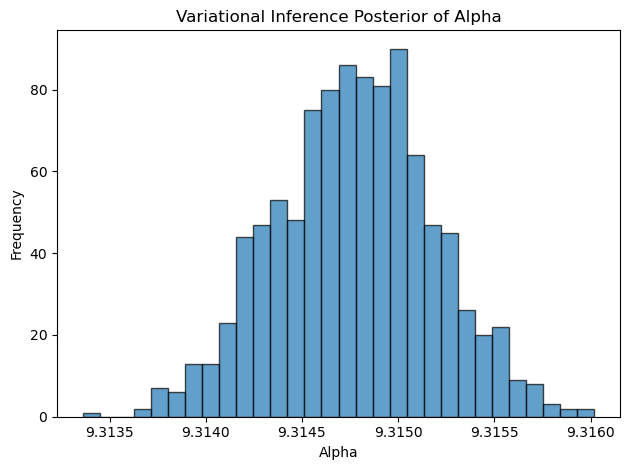

In [52]:
plt.hist(vi_alpha_samples, bins=30, edgecolor='k', alpha=0.7)
plt.title('Variational Inference Posterior of Alpha')
plt.xlabel('Alpha')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

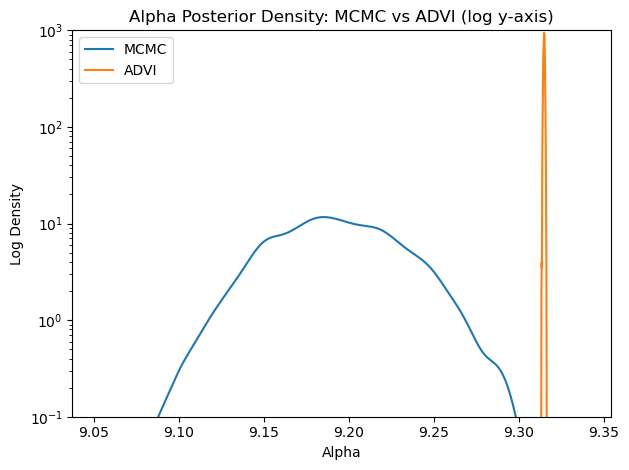

In [62]:
alpha_mcmc_samples = posterior["alpha"].values

sns.kdeplot(alpha_mcmc_samples, label='MCMC')
sns.kdeplot(vi_alpha_samples, label='ADVI')
plt.yscale('log')
plt.ylim(0.1, 1000)
plt.title('Alpha Posterior Density: MCMC vs ADVI (log y-axis)')
plt.xlabel('Alpha')
plt.ylabel('Log Density')
plt.legend()
plt.tight_layout()
plt.show()

We compared the posterior distribution of the intercept parameter `alpha` obtained from two inference methods: MCMC (run on a 100-row subsample of the data) and variational inference (ADVI, run on the full dataset).

The ADVI posterior is sharply peaked around 9.315, while the MCMC posterior is centered around 9.2 and is more spread out. This difference in center and spread is expected given the models were fit to different datasets. In particular, ADVI had access to more data, which typically leads to a more concentrated posterior.

However, the extreme narrowness of the ADVI posterior also reflects a known limitation of variational inference: it tends to **underestimate posterior uncertainty** due to its use of a Gaussian approximation.

To make the comparison more readable, we applied a log scale to the y-axis. This shows how ADVI can be overconfident and may fail to capture the true shape and spread of the posterior — particularly if not validated against full MCMC inference on the same data.

2.

Plot the same scatterplot matrix for the betas? How does it look compared to the full MCMC output?

In [63]:
# Extract beta columns from ADVI posterior
vi_beta_cols = [col for col in vi_fit.column_names if col.startswith("beta[")]
vi_beta_samples = vi_fit.variational_sample[:, [vi_fit.column_names.index(col) for col in vi_beta_cols]]
vi_beta_df = pd.DataFrame(vi_beta_samples, columns=[f'beta{i+1}' for i in range(len(vi_beta_cols))])

/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


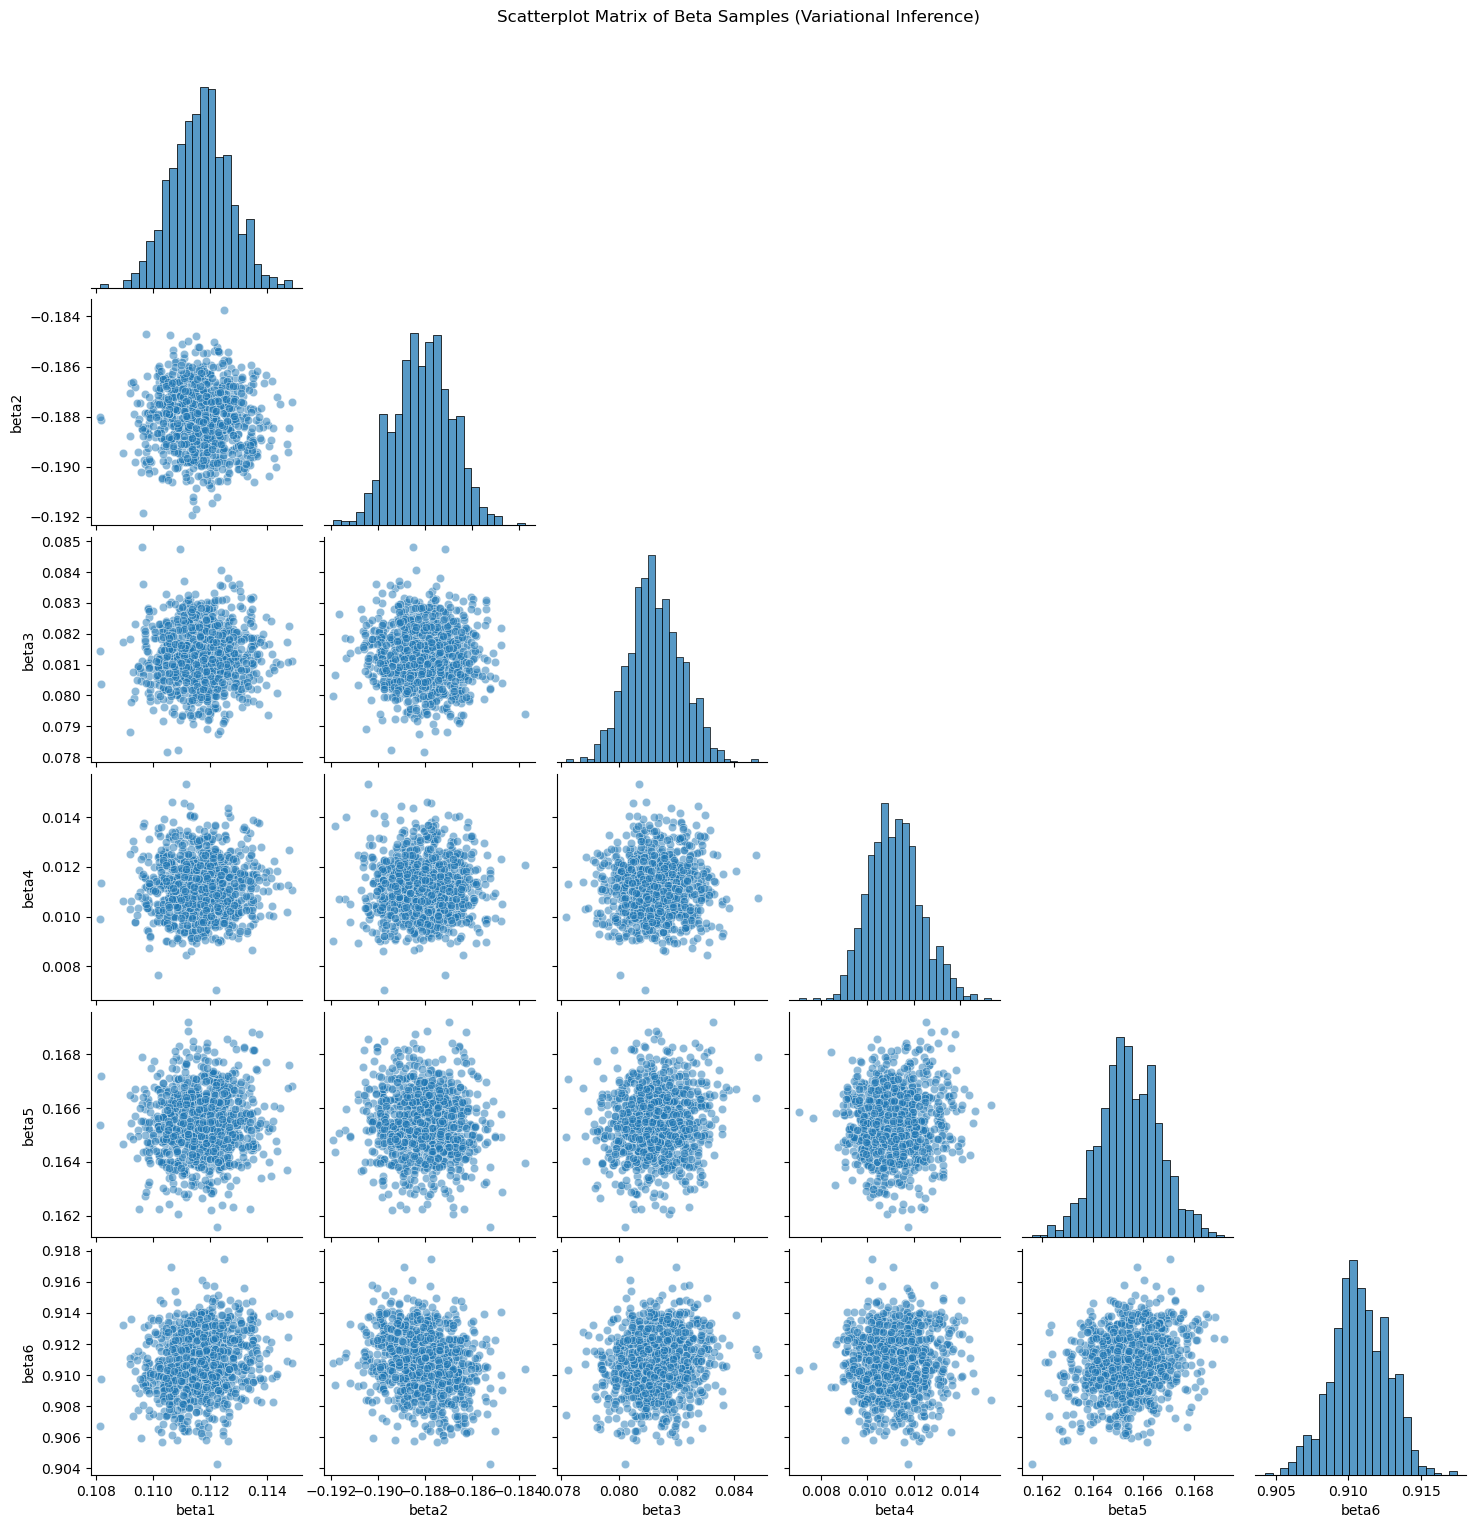

In [64]:
sns.pairplot(vi_beta_df, corner=True, plot_kws={'alpha': 0.5})
plt.suptitle('Scatterplot Matrix of Beta Samples (Variational Inference)', y=1.02)
plt.show()

/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.02, 'Scatterplot Matrix of Beta Samples (MCMC)')

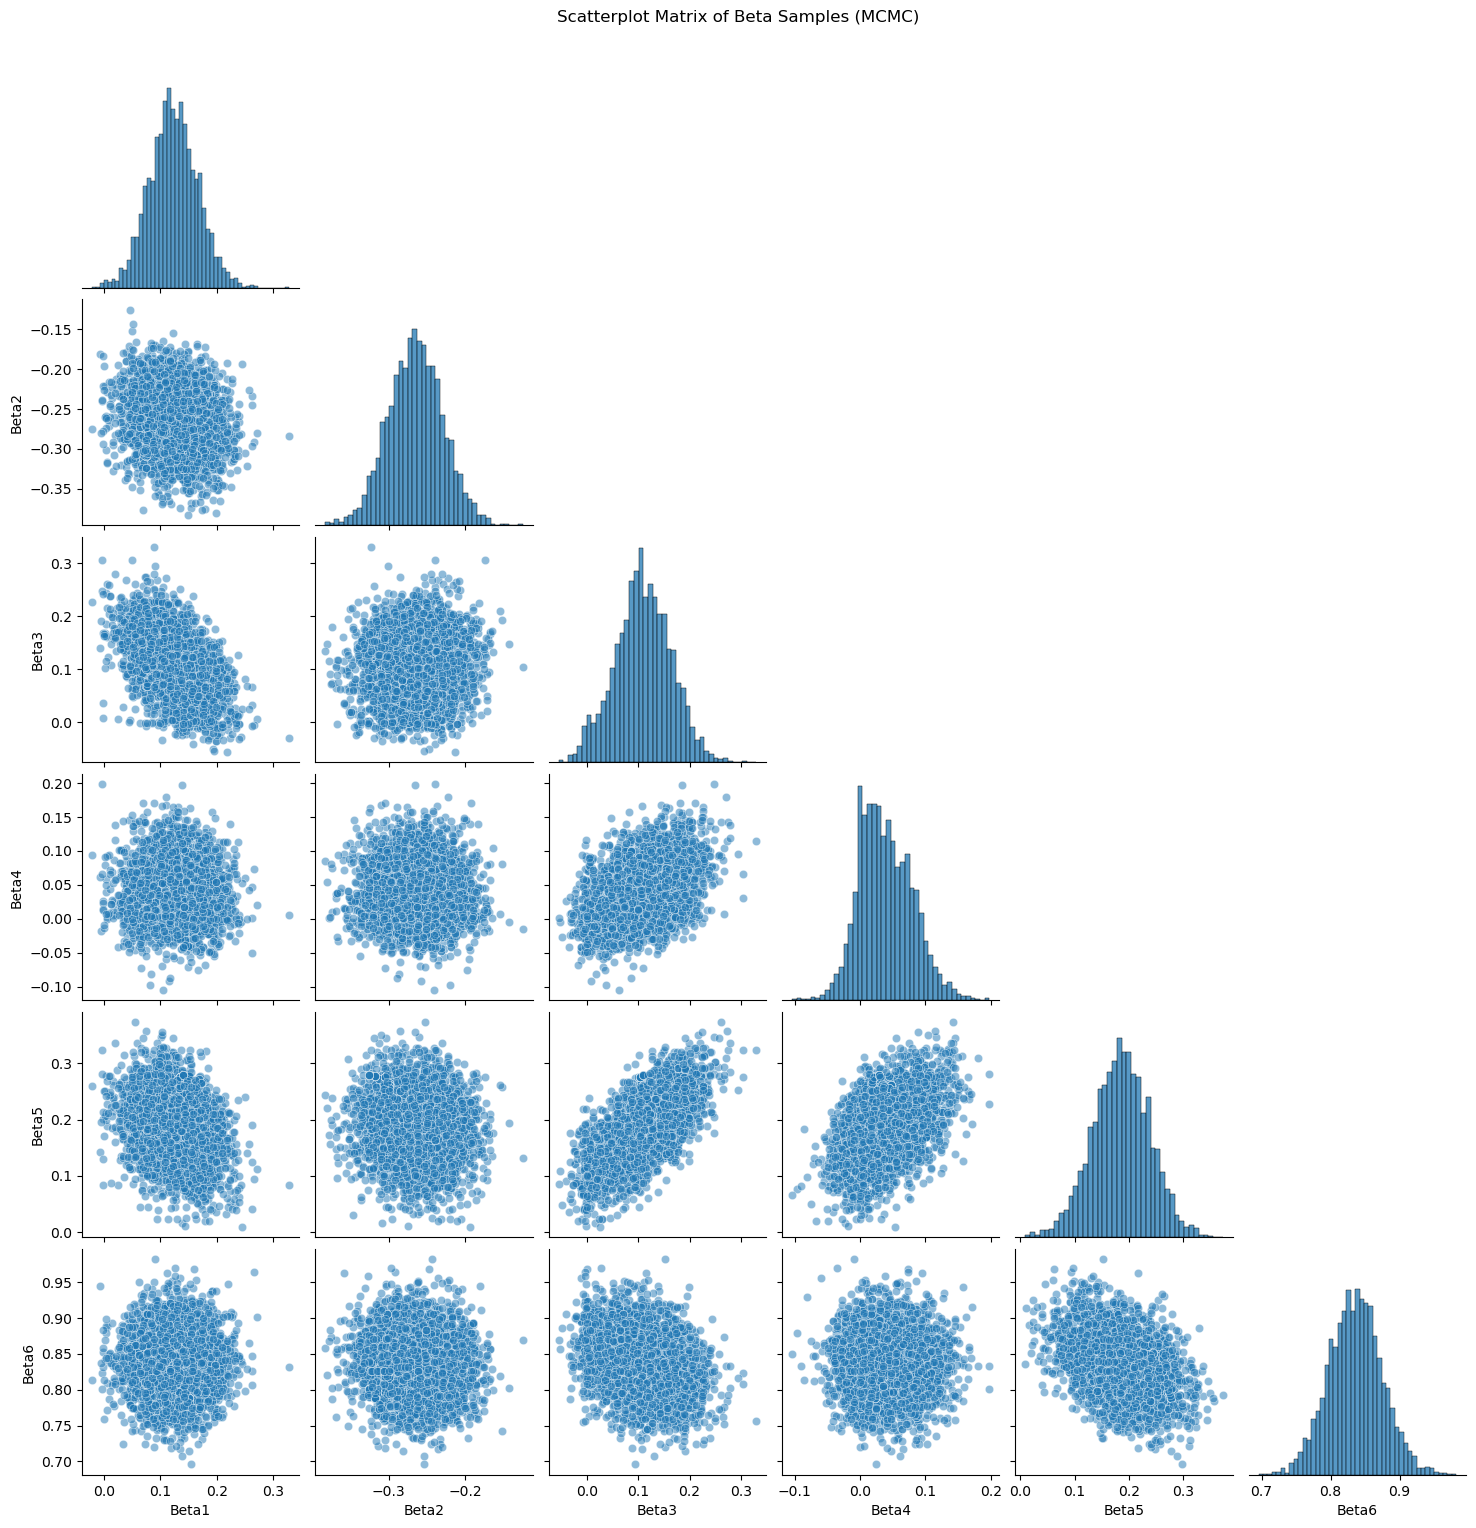

In [65]:
sns.pairplot(beta_samples, corner=True, plot_kws={'alpha': 0.5})
plt.suptitle('Scatterplot Matrix of Beta Samples (MCMC)', y=1.02)

We compared scatterplot matrices of the beta coefficients from two inference methods: MCMC (on a subsample of the data) and ADVI (on the full dataset).

One of the most striking differences is the absence of correlation structure in the variational inference output. In the MCMC results, several beta pairs exhibited clear correlations (e.g., between beta3 and beta5, or beta4 and beta5). These correlations are completely missing in the ADVI samples, which appear uncorrelated.

This is expected behavior. The default variational inference algorithm (mean-field ADVI) assumes independence between parameters to simplify the posterior approximation. While this makes the method fast and scalable, it fails to capture the true joint posterior structure, especially in models where parameters interact.

This highlights a key trade-off: ADVI offers efficiency at the cost of posterior fidelity.

## Problem 3: MAP Estimates

It still might be a bit slow for you, even if you are just running a variational algorithm. If you would like to do as the frequentists do--just optimize a function instead of trying to find the function itself--you can just find the MAP estimate:

$$
\text{argmax}_\theta \pi(\theta \mid y)
$$

At least this way we get the benefit of the prior. This is the fastest out of the three approaches so far because there is no attempt to find the posterior's function--just its mode.

1.

Use your model's `.optimize()` function to display the point estimates for your parameters.

In [66]:
map_fit = model.optimize(data=stan_data_full, seed=123)

12:06:31 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing


In [68]:
map_df = pd.DataFrame(map_fit.optimized_params_dict, index=[0]).T
map_df.columns = ['MAP Estimate']
map_df

,MAP Estimate
lp__,1.466930e+05
alpha,9.330620e+00
sigma,3.720450e-01
z[1],4.615380e-01
z[2],-5.104120e-01
z[3],4.518500e-01
z[4],-1.749490e-01
z[5],6.965240e-01
z[6],9.591560e-01
tau,6.792310e-01
